In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 100

ng =7

ng_refs = (/ 5 , 2 /) 

nref =2

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 620

data w_diffuse
     &     /1.5 , 1.5 , 1.5 , 1.5,
     &     1.5 , 1.5 , 1.5/

data wgt
     &     /0 , 0.6 , 0.5 , 0.7,
     &     0.8 , 0.8 , 0.7/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

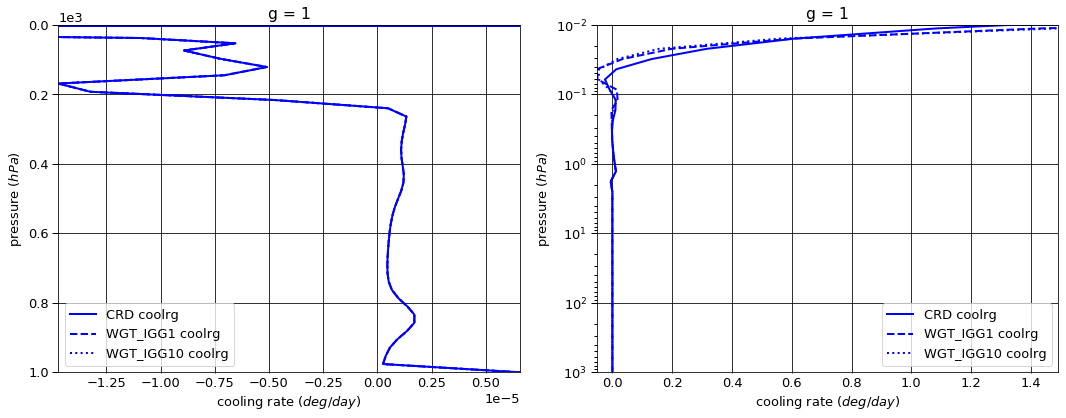

# Figure: cooling rate g-group 2

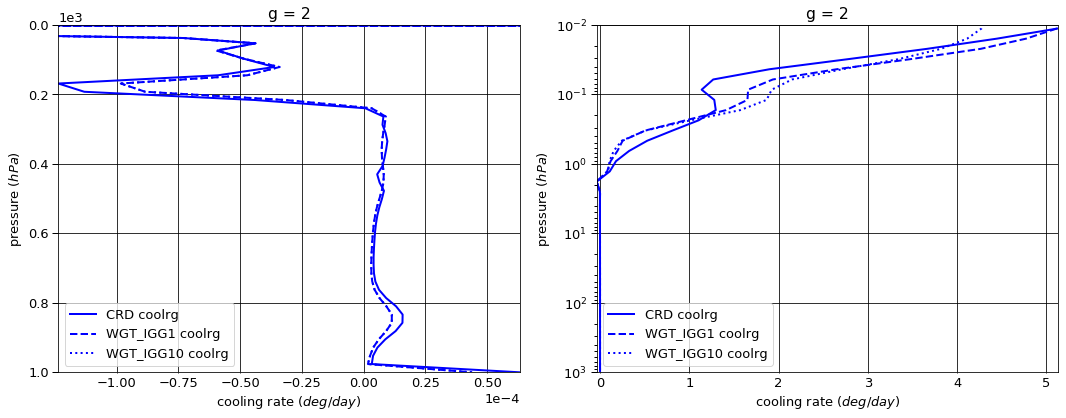

# Figure: cooling rate g-group 3

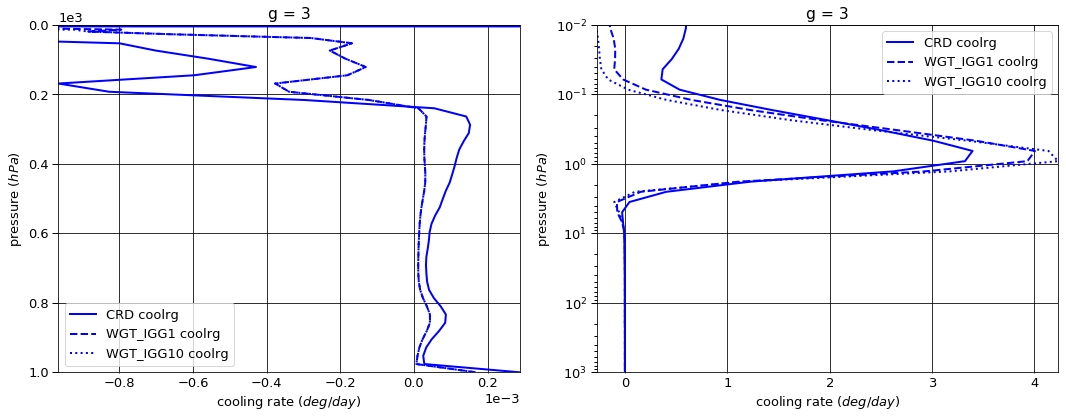

# Figure: cooling rate g-group 4

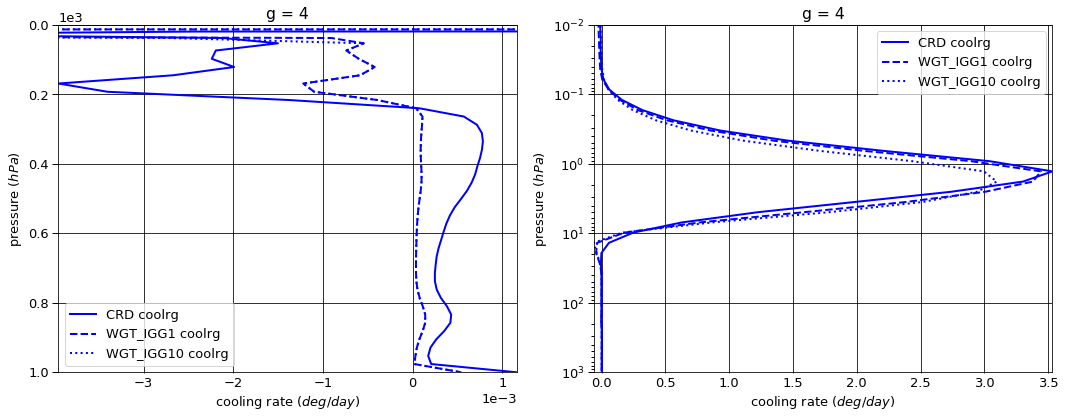

# Figure: cooling rate g-group 5

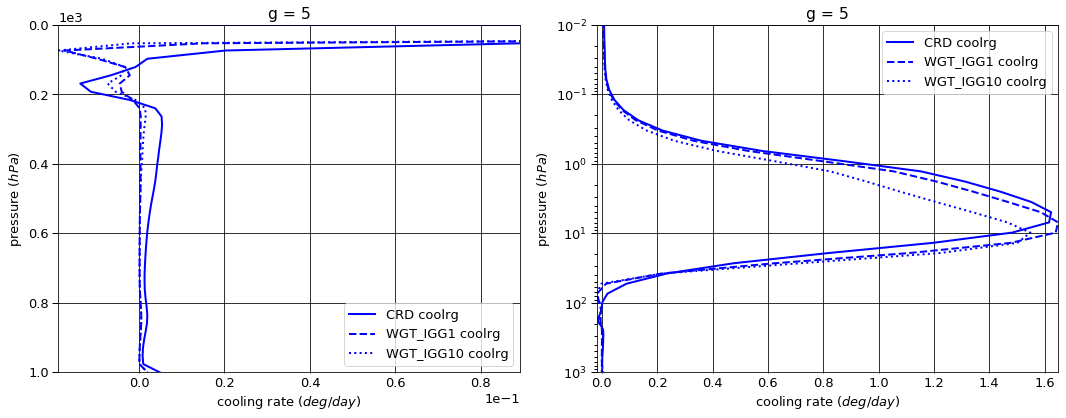

# Figure: cooling rate g-group 6

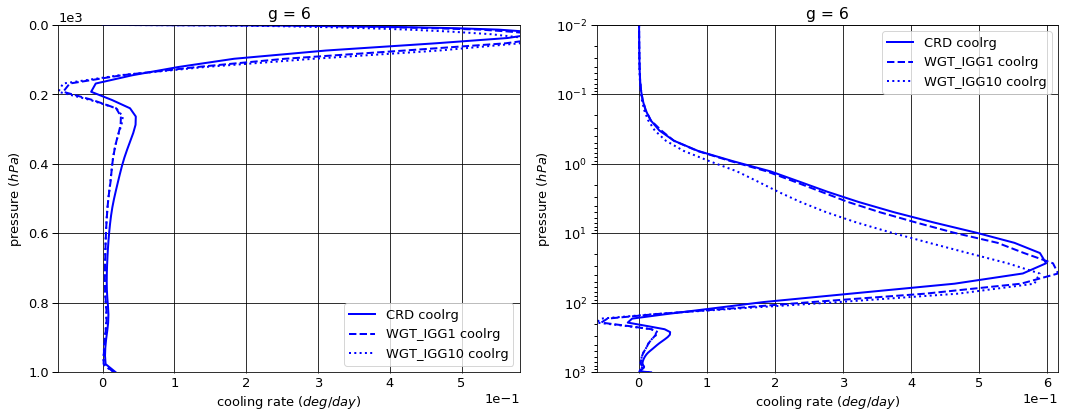

# Figure: cooling rate g-group 7

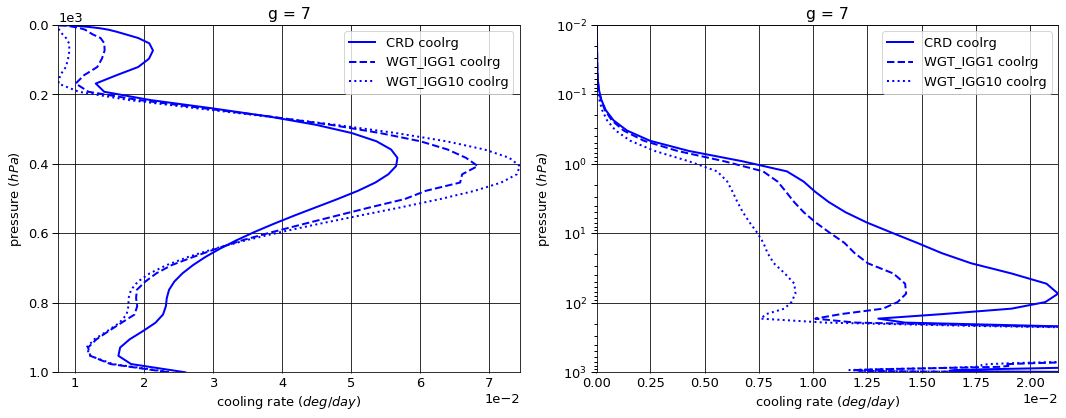

# Figure: cooling rate g-group total

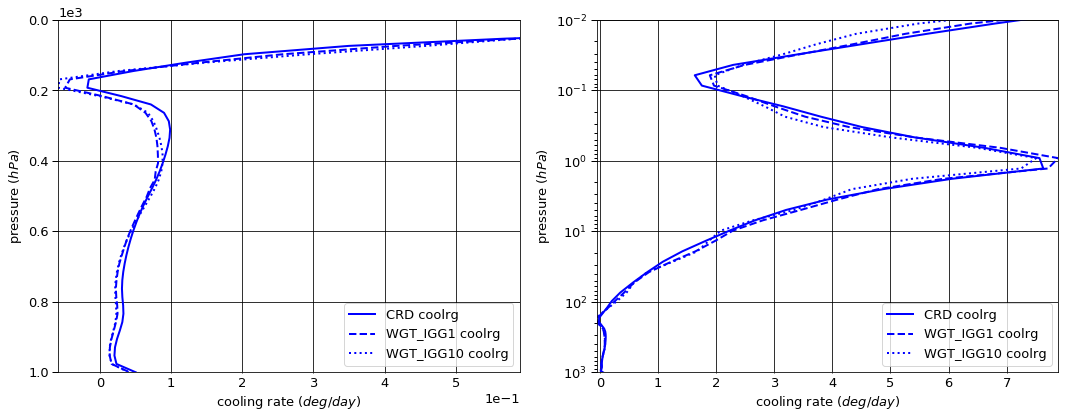

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009666   0.000000 -0.009666
  1013.0   76     -0.035280   0.035262 -0.000018
2 0.0      1      -0.090681   0.000000 -0.090681
  1013.0   76     -0.235762   0.235585 -0.000177
3 0.0      1      -0.575157   0.000000 -0.575157
  1013.0   76     -0.903647   0.902807 -0.000840
4 0.0      1      -1.709142   0.000000 -1.709142
  1013.0   76     -2.925008   2.921014 -0.003993
5 0.0      1      -4.482334   0.000000 -4.482334
  1013.0   76    -10.780553  10.762925 -0.017628
6 0.0      1      -7.064014   0.000000 -7.064014
  1013.0   76    -20.697632  20.634208 -0.063424
7 0.0      1      -3.953541   0.000000 -3.953541
  1013.0   76     -8.386956   8.162037 -0.224919


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009723   0.000000 -0.009723
  1013.0   76     -0.035280   0.035262 -0.000018
2 0.0      1      -0.081195   0.000000 -0.081195
  1013.0   76     -0.235762   0.235640 -0.000122
3 0.0      1      -0.582129   0.000000 -0.582129
  1013.0   76     -0.903647   0.903180 -0.000466
4 0.0      1      -1.773481   0.000000 -1.773481
  1013.0   76     -2.925008   2.923499 -0.001509
5 0.0      1      -4.536815   0.000000 -4.536815
  1013.0   76    -10.780553  10.774987 -0.005566
6 0.0      1      -6.819925   0.000000 -6.819925
  1013.0   76    -20.697632  20.654628 -0.043004
7 0.0      1      -3.872901   0.000000 -3.872901
  1013.0   76     -8.386956   8.251105 -0.135851


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009741   0.000000 -0.009741
  1013.0   76     -0.035280   0.035262 -0.000018
2 0.0      1      -0.081484   0.000000 -0.081484
  1013.0   76     -0.235762   0.235640 -0.000122
3 0.0      1      -0.594286   0.000000 -0.594286
  1013.0   76     -0.903647   0.903180 -0.000466
4 0.0      1      -1.758753   0.000000 -1.758753
  1013.0   76     -2.925008   2.923499 -0.001509
5 0.0      1      -4.464630   0.000000 -4.464630
  1013.0   76    -10.780553  10.774987 -0.005566
6 0.0      1      -6.737287   0.000000 -6.737287
  1013.0   76    -20.697632  20.659786 -0.037846
7 0.0      1      -3.920108   0.000000 -3.920108
  1013.0   76     -8.386956   8.253772 -0.133184


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1     -5.681610e-05  0.000000 -5.681610e-05
  1013.0   76     0.000000e+00  0.000000 -3.388132e-21
2 0.0      1      9.485253e-03  0.000000  9.485253e-03
  1013.0   76     0.000000e+00  0.000055  5.527028e-05
3 0.0      1     -6.971430e-03  0.000000 -6.971430e-03
  1013.0   76     0.000000e+00  0.000374  3.736829e-04
4 0.0      1     -6.433940e-02  0.000000 -6.433940e-02
  1013.0   76     0.000000e+00  0.002485  2.484542e-03
5 0.0      1     -5.448170e-02  0.000000 -5.448170e-02
  1013.0   76     0.000000e+00  0.012062  1.206181e-02
6 0.0      1      2.440894e-01  0.000000  2.440894e-01
  1013.0   76     3.552714e-15  0.020420  2.042027e-02
7 0.0      1      8.063970e-02  0.000000  8.063970e-02
  1013.0   76     0.000000e+00  0.089067  8.906730e-02


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1     -7.535610e-05  0.000000 -7.535610e-05
  1013.0   76     0.000000e+00  0.000000 -3.388132e-21
2 0.0      1      9.196137e-03  0.000000  9.196137e-03
  1013.0   76     0.000000e+00  0.000055  5.527028e-05
3 0.0      1     -1.912846e-02  0.000000 -1.912846e-02
  1013.0   76     0.000000e+00  0.000374  3.736829e-04
4 0.0      1     -4.961170e-02  0.000000 -4.961170e-02
  1013.0   76     0.000000e+00  0.002485  2.484542e-03
5 0.0      1      1.770330e-02  0.000000  1.770330e-02
  1013.0   76     0.000000e+00  0.012062  1.206181e-02
6 0.0      1      3.267265e-01  0.000000  3.267265e-01
  1013.0   76     3.552714e-15  0.025578  2.557831e-02
7 0.0      1      3.343300e-02  0.000000  3.343300e-02
  1013.0   76     0.000000e+00  0.091734  9.173427e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer           
1 0.000312    1      36.662098
  1001.112500 75      0.000007
2 0.000312    1       7.073837
  1001.112500 75      0.000063
3 0.000312    1       0.433388
  1001.112500 75      0.000288
4 0.000312    1      -0.036777
  1001.112500 75      0.001164
5 0.000312    1       0.004981
  1001.112500 75      0.004828
6 0.000312    1       0.000219
  1001.112500 75      0.018144
7 0.000312    1       0.000012
  1001.112500 75      0.025966


WGT_IGG1


coolrg
g pressure    layer           
1 0.000312    1      20.108678
  1001.112500 75      0.000007
2 0.000312    1       5.338815
  1001.112500 75      0.000044
3 0.000312    1      -0.282904
  1001.112500 75      0.000168
4 0.000312    1      -0.044905
  1001.112500 75      0.000544
5 0.000312    1       0.002964
  1001.112500 75      0.002006
6 0.000312    1       0.000236
  1001.112500 75      0.015581
7 0.000312    1       0.000015
  1001.112500 75      0.023550


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      16.582635
  1001.112500 75      0.000007
2 0.000312    1       3.691306
  1001.112500 75      0.000044
3 0.000312    1      -0.410807
  1001.112500 75      0.000168
4 0.000312    1      -0.024736
  1001.112500 75      0.000544
5 0.000312    1       0.003406
  1001.112500 75      0.002006
6 0.000312    1       0.000199
  1001.112500 75      0.013804
7 0.000312    1       0.000006
  1001.112500 75      0.023953


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.655342e+01
  1001.112500 75    -8.470329e-22
2 0.000312    1     -1.735022e+00
  1001.112500 75    -1.929465e-05
3 0.000312    1     -7.162923e-01
  1001.112500 75    -1.195603e-04
4 0.000312    1     -8.128050e-03
  1001.112500 75    -6.206569e-04
5 0.000312    1     -2.017612e-03
  1001.112500 75    -2.821593e-03
6 0.000312    1      1.728198e-05
  1001.112500 75    -2.563204e-03
7 0.000312    1      3.888443e-06
  1001.112500 75    -2.416670e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.007946e+01
  1001.112500 75    -8.470329e-22
2 0.000312    1     -3.382531e+00
  1001.112500 75    -1.929465e-05
3 0.000312    1     -8.441957e-01
  1001.112500 75    -1.195603e-04
4 0.000312    1      1.204119e-02
  1001.112500 75    -6.206569e-04
5 0.000312    1     -1.575094e-03
  1001.112500 75    -2.821593e-03
6 0.000312    1     -1.951977e-05
  1001.112500 75    -4.339587e-03
7 0.000312    1     -5.075888e-06
  1001.112500 75    -2.013674e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.884534,0.000000,-17.884534
1013.0,76,-43.964838,43.653839,-0.310999



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.676169,0.000000,-17.676169
1013.0,76,-43.964838,43.778301,-0.186536



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.566290,0.000000,-17.566290
1013.0,76,-43.964838,43.786126,-0.178711



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.208365,0.000000,0.208365
1013.0,76,0.000000,0.124463,0.124463



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.318243,0.000000,0.318243
1013.0,76,0.000000,0.132288,0.132288


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,44.137758
1001.112500,75,0.050460



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,25.122899
1001.112500,75,0.041899



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,19.842010
1001.112500,75,0.040526



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-19.014858
1001.112500,75,-0.008561



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-24.295748
1001.112500,75,-0.009934


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00080,0.000804
2,0.00535,0.005369
3,0.02050,0.020583
4,0.06635,0.066649
5,0.24470,0.245503
6,0.47055,0.470883
7,0.19175,0.190211


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.230874e-17
2,6.648507e-19
3,3.591161e-20
4,1.939749e-21
5,1.047746e-22
6,5.656349e-23
7,3.056898e-24


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.230874e-17,NaN,0.00080,0.000804,0.00080,0.000804,1.0
2,6.648507e-19,0.054015,0.00535,0.005369,0.00615,0.006172,1.0
3,3.591161e-20,0.054015,0.02050,0.020583,0.02665,0.026755,1.0
4,1.939749e-21,0.054015,0.06635,0.066649,0.09300,0.093403,1.0
5,1.047746e-22,0.054015,0.24470,0.245503,0.33770,0.338906,1.0
6,5.656349e-23,0.539859,0.47055,0.470883,0.80825,0.809789,10.0
7,3.056898e-24,0.054044,0.19175,0.190211,1.00000,1.000000,10.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.472929e-17  1.904644e-17   2.873465  1.008219e-01
      2 0.000312     1.001437e-18  5.337776e-19   1.876131  4.310867e-03
      3 0.000312     4.930607e-20  1.504617e-20   3.276984  1.703236e-04
      4 0.000312     1.317415e-21  4.426496e-22   2.976203  5.584543e-06
      5 0.000312     3.029631e-23  1.038498e-23   2.917320  1.392929e-07
      6 0.000312     4.588661e-25  4.105996e-25   1.117551  2.377898e-09
      7 0.000312     1.564667e-25  7.502997e-26   2.085390  6.989281e-10
2     1 0.000750     5.473178e-17  1.907059e-17   2.869957  4.066122e-02
      2 0.000750     1.005275e-18  5.356376e-19   1.876782  1.742856e-03
      3 0.000750     4.948532e-20  1.514117e-20   3.268263  6.889644e-05
      4 0.000750     1.325908e-21  4.472362e-22   2.964670  2.264989e-06
      5 0.000750     3.060704e-23  1.059465e-23   2.888915  5.672472e-08
      6 0.000750     4.752288e-25  4.264510e-25   1.114381  9.924553e-10
      7 0.000750     1.586986e-25  7.613027e-26   2.084566  2.855538e-10
3     1 0.001052     5.473633e-17  1.911695e-17   2.863235  5.716134e-02
      2 0.001052     1.013035e-18  5.390697e-19   1.879229  2.462184e-03
      3 0.001052     4.981574e-20  1.526607e-20   3.263167  9.730011e-05
      4 0.001052     1.340464e-21  4.527590e-22   2.960656  3.211808e-06
      5 0.001052     3.105434e-23  1.081049e-23   2.872612  8.074898e-08
      6 0.001052     4.920550e-25  4.421474e-25   1.112875  1.441441e-09
      7 0.001052     1.626318e-25  7.760642e-26   2.095597  4.100132e-10
4     1 0.001476     5.474085e-17  1.916673e-17   2.856035  8.039999e-02
      2 0.001476     1.021371e-18  5.427983e-19   1.881677  3.481414e-03
      3 0.001476     5.017848e-20  1.541136e-20   3.255942  1.375671e-04
      4 0.001476     1.356665e-21  4.593237e-22   2.953613  4.561653e-06
      5 0.001476     3.157073e-23  1.107812e-23   2.849826  1.152395e-07
      6 0.001476     5.130873e-25  4.619457e-25   1.110709  2.109377e-09
      7 0.001476     1.670341e-25  7.933747e-26   2.105363  5.903093e-10
5     1 0.002070     5.474509e-17  1.921775e-17   2.848674  1.130681e-01
      2 0.002070     1.029880e-18  5.466816e-19   1.883875  4.922161e-03
      3 0.002070     5.056023e-20  1.557790e-20   3.245638  1.945627e-04
      4 0.002070     1.374064e-21  4.670593e-22   2.941947  6.483425e-06
      5 0.002070     3.215389e-23  1.140944e-23   2.818184  1.647682e-07
      6 0.002070     5.393022e-25  4.868843e-25   1.107660  3.111318e-09
      7 0.002070     1.717817e-25  8.133823e-26   2.111943  8.510444e-10
6     1 0.002904     5.474910e-17  1.927046e-17   2.841090  1.590399e-01
      2 0.002904     1.038599e-18  5.507745e-19   1.885706  6.961188e-03
      3 0.002904     5.096643e-20  1.577384e-20   3.231073  2.754052e-04
      4 0.002904     1.393048e-21  4.764204e-22   2.923988  9.227395e-06
      5 0.002904     3.282766e-23  1.182928e-23   2.775119  2.362680e-07
      6 0.002904     5.727101e-25  5.189713e-25   1.103549  4.637901e-09
      7 0.002904     1.769781e-25  8.371364e-26   2.114089  1.229693e-09
7     1 0.004074     5.475294e-17  1.932556e-17   2.833187  2.237350e-01
      2 0.004074     1.047591e-18  5.551580e-19   1.887015  9.847735e-03
      3 0.004074     5.140514e-20  1.601053e-20   3.210708  3.902408e-04
      4 0.004074     1.414176e-21  4.880424e-22   2.897651  1.315554e-05
      5 0.004074     3.362593e-23  1.237233e-23   2.717833  3.400813e-07
      6 0.004074     6.161486e-25  5.610360e-25   1.098234  7.005637e-09
      7 0.004074     1.827737e-25  8.661359e-26   2.110220  1.782021e-09
8     1 0.005714     5.475667e-17  1.938405e-17   2.824832  3.147784e-01
      2 0.005714     1.056945e-18  5.599454e-19   1.887586  1.393546e-02
      3 0.005714     5.188763e-20  1.630358e-20   3.182592  5.536800e-04
      4 0.005714     1.438234e-21  5.028011e-22   2.860444  1.879839e-05
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
